In [70]:
# 01_data_cleaning.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sqlite3

# 连接爬虫数据库
DB_PATH = Path('../data/raw/wos.db')          # 相对 notebooks 目录
conn    = sqlite3.connect(DB_PATH)

# 中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
print("✅ SQLite 环境完成，路径：", DB_PATH.resolve())

✅ SQLite 环境完成，路径： C:\Users\28623\OneDrive\Desktop\BankJournalAnalysis\data\raw\wos.db


In [71]:
#  第二个单元格 读取真实爬取结果（tsinghua 为例，可改成列表循环）
school     = 'tsinghua_university'
raw_df     = pd.read_sql(f'SELECT * FROM "{school}"', conn)

print(f"📥 原始数据形状: {raw_df.shape}")
print(f"时间范围: {raw_df['pub_date'].min()} - {raw_df['pub_date'].max()}")
print(f"期刊数量: {raw_df['source'].nunique()}")
raw_df.head()

📥 原始数据形状: (1100, 11)
时间范围: 2003 - Win 2022
期刊数量: 792


,id,address,title,authors,pub_date,conference,source,citations,refs,wos_id,abstract
0,1,"Tsinghua Univ, Beijing, Peoples R China",Effects of wall cooling on hypersonic shock wa...,"Tang, AZ; Xu, BH; ...; Ren, DJ",Nov 2025,None,AERONAUTICAL JOURNAL,0,31,001534493600001,Wall cooling is a promising method in controll...
1,2,"Tsinghua Univ, Beijing, Peoples R China",Designing an Efficient Tree Index on Disaggreg...,"Wang, Q; Lu, YY; Shu, JW",May 2025,None,COMMUNICATIONS OF THE ACM,0,25,001485085000018,Memory disaggregation architecture physically ...
2,3,"Tsinghua Univ, Beijing, Peoples R China",The dual roles of lymphotoxin-β in promoting b...,"Wang, XX; Zheng, HQ",Sep 2024,None,NATURE CELL BIOLOGY,0,5,001302656500002,Using single-cell RNA sequencing analysis of b...
3,4,"Tsinghua Univ, Beijing, Peoples R China",A 24.3-to-44.8 GHz Reconfigurable Dual-Band T/...,"Gong, JL; Deng, W; ...; Chi, BY",2024,IEEE International Symposium on Circuits and S...,2024 IEEE INTERNATIONAL SYMPOSIUM ON CIRCUITS ...,0,8,001268541101162,This paper presents a multi-band front-end mod...
4,5,"Tsinghua Univ, Beijing, Peoples R China",Predictive Effects of English Classroom Anxiet...,"Liu, MH; Li, TH",2024,None,JOURNAL OF LANGUAGE AND EDUCATION,0,68,001265026100006,Background: Second language (L2) learning is c...


In [72]:
# 第三个单元格：基础清洗（期刊+年份+缺失处理）
df = raw_df.copy()

# 1. 缺失填充
df['abstract']   = df['abstract'].fillna('')
df['conference'] = df['conference'].fillna('')
df['citations']  = df['citations'].fillna(0).astype(int)
df['refs']       = df['refs'].fillna(0).astype(int)

# 2. 踢掉会议录
conf_kws = [
    'proceedings', 'conference', 'companion', 'symposium', 'workshop',
    'iccv', 'cvpr', 'eccv', 'icml', 'neurips', 'nips', 'chi', 'hri', 'icde',
    'siggraph', 'mm ', 'icra', 'iros', 'ecc', 'esscirc', 'ieee/cvf'
]

pattern = '|'.join(conf_kws)
df = df[~df['source'].str.contains(pattern, case=False, na=False)]
print(f"📚 去会议后: {df.shape[0]} 条")

# 3. 年份解析 + 2010-2024 过滤
df['year'] = pd.to_datetime(df['pub_date'], errors='coerce').dt.year
df = df.dropna(subset=['year'])
df = df[df['year'].between(2010, 2024)]
print(f"📅 年份过滤后: {df.shape[0]} 条 (2010-2024)")

# 4. 落盘
OUT_DIR = Path('../data/cleaned')
OUT_DIR.mkdir(exist_ok=True)
clean_file = OUT_DIR / f'{school}_cleaned.csv'
df.to_csv(clean_file, index=False, encoding='utf-8')

print(f"✅ 已保存: {clean_file} , 最终形状: {df.shape}")
df.head()

📚 去会议后: 365 条
📅 年份过滤后: 275 条 (2010-2024)
✅ 已保存: ..\data\cleaned\tsinghua_university_cleaned.csv , 最终形状: (275, 12)


,id,address,title,authors,pub_date,conference,source,citations,refs,wos_id,abstract,year
2,3,"Tsinghua Univ, Beijing, Peoples R China",The dual roles of lymphotoxin-β in promoting b...,"Wang, XX; Zheng, HQ",Sep 2024,,NATURE CELL BIOLOGY,0,5,001302656500002,Using single-cell RNA sequencing analysis of b...,2024.0
4,5,"Tsinghua Univ, Beijing, Peoples R China",Predictive Effects of English Classroom Anxiet...,"Liu, MH; Li, TH",2024,,JOURNAL OF LANGUAGE AND EDUCATION,0,68,001265026100006,Background: Second language (L2) learning is c...,2024.0
9,10,"Tsinghua Univ, Beijing, Peoples R China",Soju: A Global History,"Revells, T",Feb 2022,,JOURNAL OF ASIAN STUDIES,0,1,000768359300056,,2022.0
10,11,"Tsinghua Univ, Beijing, Peoples R China",Lyricism and Implicit Emotional Expression of ...,"Chen, PH; Rau, PLP",2022,14th International Conference on Cross-Cultura...,CROSS-CULTURAL DESIGN-APPLICATIONS IN LEARNING...,0,47,001292829600012,Lots of music pieces are blooming with interne...,2022.0
11,12,"Tsinghua Univ, Beijing, Peoples R China",Statistical Algorithm Enables Rapid Computatio...,"Zhou, XY; Liu, XW; Ouyang, Z",Feb 2020,,JOURNAL OF THE AMERICAN SOCIETY FOR MASS SPECT...,6,37,000516075800030,Computation of the space charge effect within ...,2020.0


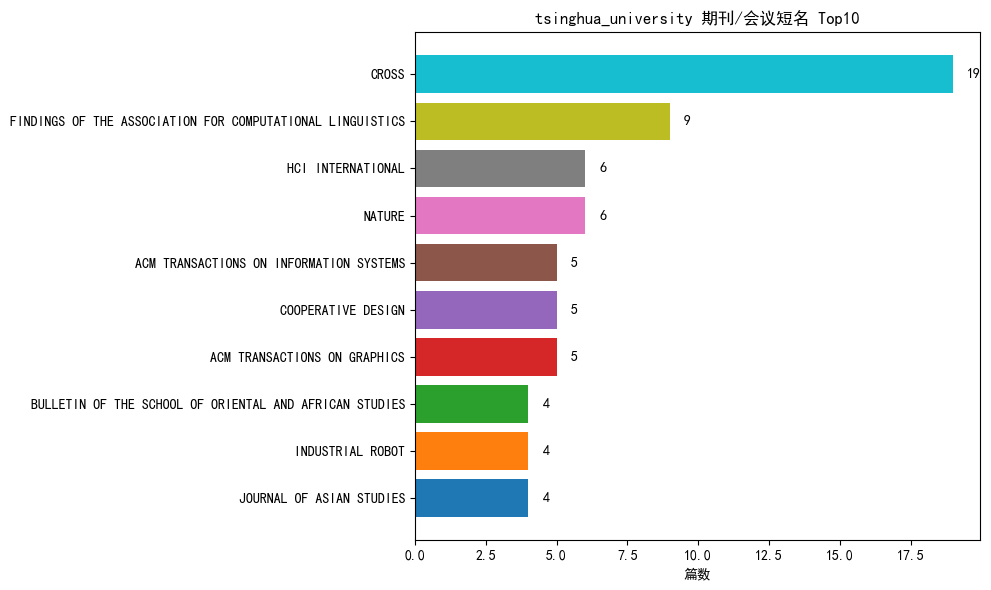

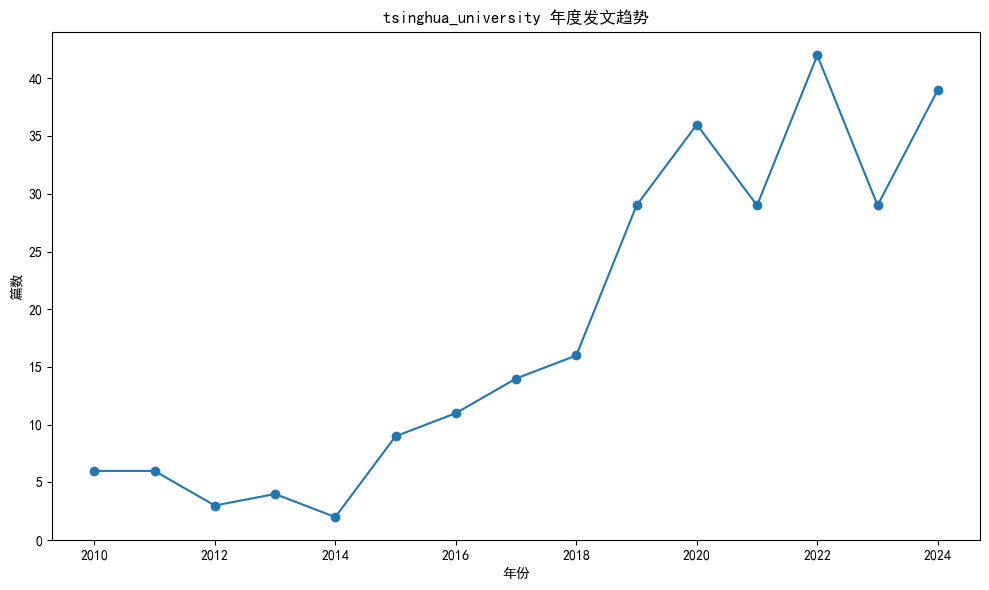

In [73]:
# 期刊分布 第四个单元格
# 提取短名
df['short_source'] = df['source'].str.extract(r'([A-Z]{2,}(?:\s[A-Z]{2,})*)')[0].fillna(df['source'])

# 只取 Top10
top10 = df['short_source'].value_counts().head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10.index[::-1], top10.values[::-1], color=plt.cm.tab10(range(10)))
plt.title(f'{school} 期刊/会议短名 Top10')
plt.xlabel('篇数')
for i, v in enumerate(top10.values[::-1]):
    plt.text(v + 0.5, i, str(v), va='center')
plt.tight_layout()
plt.show()
# 年份趋势
plt.figure(figsize=(10, 6))
year_counts = df['year'].value_counts().sort_index()
plt.plot(year_counts.index, year_counts.values, marker='o')
plt.title(f'{school} 年度发文趋势')
plt.xlabel('年份')
plt.ylabel('篇数')
plt.tight_layout()
plt.show()